### Customer Payment (Revenue) Prediction
#### Author: Qingchuan Lyu
__Goal__: we want to learn more about the users who started the new new service during November 2020.  

__Problems__:

Using only the first 7 days of payments and events, what is our best prediction for day 60 revenue.  We can model per user and/or aggregates grouped by platform, channel and geo.

__Strategy Highlights__:
* To predict day 60 revenue with the first 7 days of payments and events, I computed the total revenue on day 60 for each combination of platform, channel and geo. According to total revenue on day 60 and the sample size of each combination, I divided users into 4 groups ('combo_category' = 0, 1, 2, 3) and found the optimal model for each group. See Section [Grouping Users](#group).
* Building a PCA pipeline most often significantly reduced RMSE. The only exception was the last group (combo_category = 3), where a simple OLS model outperformed all the other regularized linear models and tree models on the out-of-sample data. See Section [Modeling](#model).

[References](#References)

[Appendix: Failed Attempts](#Appendix)

In [7]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# Store plots in notebook.
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [8]:
# Import input files
users_df = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Companies/EA/take home/dataset/users.csv")

In [9]:
users_df.head()

,user,platform,channel,geo,install_date
0,-6850362954315242018,purple,Mice,AB,2020-11-03
1,7863223365093340651,purple,Mice,AB,2020-11-03
2,-5844463704494523566,purple,Mice,AB,2020-11-03
3,-2710245180531833391,purple,Mice,AB,2020-11-03
4,-1227926074670215435,purple,Mice,AB,2020-11-03


In [10]:
events_all = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Companies/EA/take home/dataset/all_events.csv")

In [11]:
events_all.head()

,user,event,event_time
0,8629825311730842634,__UNINSTALL__,2020-10-04 01:02:53 UTC
1,7969139209064461440,checkpoint_d,2020-11-14 23:22:21 UTC
2,5997886761676625641,checkpoint_b,2020-10-12 20:42:05 UTC
3,8439996094898480238,__UNINSTALL__,2020-11-10 02:44:21 UTC
4,987174099125648640,checkpoint_c,2020-12-03 17:23:01 UTC


In [12]:
revenue_df = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Companies/EA/take home/dataset/revenue_transactions.csv")

In [13]:
revenue_df.head()

,user,revenue,event_time_unix
0,-5857284260667862713,391.840,1607719843
1,-5320862144580316075,73.346,1606075953
2,7479991034279227950,74.834,1609396933
3,-4613260486179764053,160.766,1608685422
4,-4628126647390979390,137.764,1608662419


### Cleaning

In [14]:
users_df.dtypes

user             int64
platform        object
channel         object
geo             object
install_date    object
dtype: object

In [15]:
# Users table: transfer the datatype of 'install_date'
users_df['install_datetime'] = pd.to_datetime(users_df['install_date'])
# Check if any user data was before or later than November 2020
users_df[(users_df['install_datetime'] < '2020-11-01') | (users_df['install_datetime'] > '2020-11-30')]

,user,platform,channel,geo,install_date,install_datetime


All users in the user table were within the study window of November 2020.

In [16]:
users_df.dtypes

user                         int64
platform                    object
channel                     object
geo                         object
install_date                object
install_datetime    datetime64[ns]
dtype: object

In [17]:
# Revenue table: transfer unix time to a normal date type
revenue_df['transaction_time'] = pd.to_datetime(revenue_df['event_time_unix'],unit='s')

In [18]:
revenue_df.head()

,user,revenue,event_time_unix,transaction_time
0,-5857284260667862713,391.840,1607719843,2020-12-11 20:50:43
1,-5320862144580316075,73.346,1606075953,2020-11-22 20:12:33
2,7479991034279227950,74.834,1609396933,2020-12-31 06:42:13
3,-4613260486179764053,160.766,1608685422,2020-12-23 01:03:42
4,-4628126647390979390,137.764,1608662419,2020-12-22 18:40:19


In [19]:
revenue_df.dtypes

user                         int64
revenue                    float64
event_time_unix              int64
transaction_time    datetime64[ns]
dtype: object

In [20]:
# Check if any transaction time was before November 2020 in the revenues table
revenue_df[revenue_df['transaction_time'] < '2020-11-01']

,user,revenue,event_time_unix,transaction_time
41,-9158721160290802642,13.392,1597097160,2020-08-10 22:06:00
64,7758665106893810672,15.686,1599250474,2020-09-04 20:14:34
184,3504962259294482717,33.480,1601243176,2020-09-27 21:46:16
189,3213188719188095811,23.560,1601545713,2020-10-01 09:48:33
265,3562288386363372448,33.666,1602860273,2020-10-16 14:57:53
...,...,...,...,...
277011,-7225198879896254107,61.938,1599250510,2020-09-04 20:15:10
277040,-2196858143486580488,61.938,1600802203,2020-09-22 19:16:43
277069,5774997814734506718,61.938,1603545195,2020-10-24 13:13:15
277075,2715677088331392770,61.938,1596716991,2020-08-06 12:29:51


In [21]:
# Add 'install_datetime' to the revenues table for each user
revenue_df = revenue_df.merge(users_df[['user', 'install_datetime']], on = 'user', how = 'left')
# Restrict to revenue transactions after 'install_datetime'
revenue_df = revenue_df[revenue_df['transaction_time'] >= revenue_df['install_datetime']]

In [22]:
# Transfer 'event_time' from object to datetime
events_all['event_datetime'] = pd.to_datetime(events_all['event_time']).dt.tz_convert(None)
# Add install dates of each users to the events table
events_all = events_all.merge(users_df[['user', 'install_datetime']], how = 'left', on = 'user')

In [23]:
events_all['events_day_diff'] = (events_all['event_datetime'] - events_all['install_datetime']).dt.days

In [24]:
# Remove events when 'event_datetime' was before 'install_date' for a user, or after 7 days of 'install_date'
events_df = events_all[(events_all['events_day_diff'] <= 7) & (events_all['events_day_diff'] >= 1)]

In [25]:
# Difference between transaction time and installation time
revenue_df['rev_day_diff'] = (revenue_df['transaction_time'] - revenue_df['install_datetime']).dt.days

In [23]:
# Remove transactions before 'install_date' for a user, or after 7 days of 'install_date'
rev_study_period = revenue_df[revenue_df['rev_day_diff'].isin((1, 2, 3, 4, 5, 6, 7))]
# Create daily revenue for users
rev_study_period = rev_study_period.groupby(['user', 'rev_day_diff', 'install_datetime'])\
                                   .agg(daily_rev = ('revenue', 'sum'))\
                                   .reset_index()

In [24]:
rev_study_period.sort_values(by = ['user'])

,user,rev_day_diff,install_datetime,daily_rev
0,-9223024671825712078,7,2020-11-06,86.614
1,-9222407629623737699,6,2020-11-19,63.488
2,-9222407629623737699,7,2020-11-19,158.844
3,-9221115360712779506,6,2020-11-07,362.514
4,-9221115360712779506,7,2020-11-07,92.194
...,...,...,...,...
20261,9214623768181784609,4,2020-11-28,30.938
20262,9215003010450134224,1,2020-11-28,142.352
20263,9215379809662654789,3,2020-11-27,247.876
20264,9216381112594331202,6,2020-11-28,30.938


In [25]:
# Sum up day 60 revenue for users
users_d60 = revenue_df[revenue_df['rev_day_diff'] == 60].groupby('user')\
                                                        .agg(revenue_d60 = ('revenue', 'sum'))\
                                                        .reset_index()

In [26]:
users_d60.head()

,user,revenue_d60
0,-9207576918249685972,123.938
1,-9173585236325656261,123.938
2,-9162440965433711475,137.640
3,-9161367584164921409,30.814
4,-9157165326575102981,805.566


In [27]:
# Add day 60 revenue to the revenue table
rev_study_period = rev_study_period.merge(users_d60, on = 'user', how = 'outer')

In [28]:
rev_study_period

,user,rev_day_diff,install_datetime,daily_rev,revenue_d60
0,-9223024671825712078,7.0,2020-11-06,86.614,NaN
1,-9222407629623737699,6.0,2020-11-19,63.488,NaN
2,-9222407629623737699,7.0,2020-11-19,158.844,NaN
3,-9221115360712779506,6.0,2020-11-07,362.514,NaN
4,-9221115360712779506,7.0,2020-11-07,92.194,NaN
...,...,...,...,...,...
20926,9125030842078137741,NaN,NaT,NaN,123.938
20927,9149422826372800343,NaN,NaT,NaN,123.938
20928,9179070853256280581,NaN,NaT,NaN,30.938
20929,9223133388388252066,NaN,NaT,NaN,123.938


In [29]:
rev_study_period['rev_day_diff'].value_counts()

1.0    4241
2.0    3124
3.0    2755
5.0    2621
4.0    2577
6.0    2525
7.0    2423
Name: rev_day_diff, dtype: int64

In [30]:
rev_study_period[rev_study_period['revenue_d60'] > 0]['rev_day_diff'].value_counts()

5.0    279
4.0    264
6.0    261
3.0    256
2.0    255
7.0    255
1.0    253
Name: rev_day_diff, dtype: int64

In [31]:
rev_study_period[rev_study_period['revenue_d60'].isnull()]['rev_day_diff'].value_counts()

1.0    3988
2.0    2869
3.0    2499
5.0    2342
4.0    2313
6.0    2264
7.0    2168
Name: rev_day_diff, dtype: int64

Compare payments within 7 days of installation by different day 60 revenue
* Most payments were made right after the installation day.
* No matter restricting to users with or without payments on day 60, most users made a payment on the first day after installation dates.

In [32]:
# Pivot daily revenues (7 days after installation)
rev_daily = rev_study_period.pivot(index=['user', 'install_datetime', 'revenue_d60']\
                                   , columns='rev_day_diff'\
                                   , values='daily_rev')
rev_daily.head()

,,rev_day_diff,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0
user,install_datetime,revenue_d60,,,,,,,,
-9223024671825712078,2020-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.614
-9222407629623737699,2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.488,158.844
-9221115360712779506,2020-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362.514,92.194
-9219913297147836699,2020-11-27,NaN,NaN,NaN,NaN,30.938,NaN,30.938,NaN,NaN
-9216925406964736628,2020-11-18,NaN,NaN,309.628,NaN,NaN,NaN,9.238,89.652,NaN


In [33]:
# Clean up column headers
rev_daily.index.name
rev_daily = rev_daily.rename_axis(None, axis=1).reset_index()

In [34]:
rev_daily.head()

,user,install_datetime,revenue_d60,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,-9223024671825712078,2020-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.614
1,-9222407629623737699,2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.488,158.844
2,-9221115360712779506,2020-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362.514,92.194
3,-9219913297147836699,2020-11-27,NaN,NaN,NaN,NaN,30.938,NaN,30.938,NaN,NaN
4,-9216925406964736628,2020-11-18,NaN,NaN,309.628,NaN,NaN,NaN,9.238,89.652,NaN


In [35]:
# Remove the 'NaN' column
# The NaN column is the value of revenue within the first 7 days when there's only payments on day 60
rev_daily = rev_daily.loc[:, rev_daily.columns.notnull()]

In [36]:
rev_daily.head()

,user,install_datetime,revenue_d60,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,-9223024671825712078,2020-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.614
1,-9222407629623737699,2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,63.488,158.844
2,-9221115360712779506,2020-11-07,NaN,NaN,NaN,NaN,NaN,NaN,362.514,92.194
3,-9219913297147836699,2020-11-27,NaN,NaN,NaN,30.938,NaN,30.938,NaN,NaN
4,-9216925406964736628,2020-11-18,NaN,309.628,NaN,NaN,NaN,9.238,89.652,NaN


In [37]:
# Rename columns as rev_day_0, ..., rev_day_7
rev_daily.rename(columns={1 : 'rev_day_1', 2 : 'rev_day_2', 3 : 'rev_day_3', 4 : 'rev_day_4'\
                          , 5 : 'rev_day_5', 6 : 'rev_day_6', 7 : 'rev_day_7'}\
                , inplace=True)

In [38]:
rev_daily = rev_daily.drop(['install_datetime'], axis = 1)
rev_daily.head()

,user,revenue_d60,rev_day_1,rev_day_2,rev_day_3,rev_day_4,rev_day_5,rev_day_6,rev_day_7
0,-9223024671825712078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.614
1,-9222407629623737699,NaN,NaN,NaN,NaN,NaN,NaN,63.488,158.844
2,-9221115360712779506,NaN,NaN,NaN,NaN,NaN,NaN,362.514,92.194
3,-9219913297147836699,NaN,NaN,NaN,30.938,NaN,30.938,NaN,NaN
4,-9216925406964736628,NaN,309.628,NaN,NaN,NaN,9.238,89.652,NaN


In [39]:
# The table events_df is restricted to events 7 days after installation
events_df.head()

,user,event,event_time,event_datetime,install_datetime,events_day_diff
4,987174099125648640,checkpoint_c,2020-12-03 17:23:01 UTC,2020-12-03 17:23:01,2020-11-29,4
7,-5875944197577849825,checkpoint_c,2020-12-04 05:12:55 UTC,2020-12-04 05:12:55,2020-11-30,4
8,880185644960156078,checkpoint_s,2020-12-02 03:48:11 UTC,2020-12-02 03:48:11,2020-11-29,3
9,-3854780075935461278,checkpoint_g,2020-12-01 22:33:13 UTC,2020-12-01 22:33:13,2020-11-25,6
15,-5695543000262062576,checkpoint_j,2020-11-08 04:39:40 UTC,2020-11-08 04:39:40,2020-11-01,7


In [40]:
# Check if a user has more than one event on a day
len(events_df.groupby(['user', 'events_day_diff'])), len(events_df)

(42684, 80389)

In [41]:
# Check if any user has multiple payments within 7 days of installation
rev_study_period['user'].nunique(), len(rev_study_period['user'])

(12919, 20931)

Below shows payments came with the event '_iap_' after 7 days of installation, when there's at least a payment and an event on a day, there must be an '_iap_' event.

In [56]:
# Check the relationshiop between events and payments
events_revenue = events_df.merge(rev_study_period[['user', 'daily_rev', 'rev_day_diff']]\
                                  , left_on = ['user', 'events_day_diff'], right_on = ['user', 'rev_day_diff']\
                                  , how = 'inner')
events_revenue.head()

,user,event,event_time,event_datetime,install_datetime,events_day_diff,daily_rev,rev_day_diff
0,3630791608746977685,checkpoint_f,2020-12-02 02:26:02 UTC,2020-12-02 02:26:02,2020-11-29,3,37.138,3.0
1,3630791608746977685,__iap__,2020-12-02 16:34:49 UTC,2020-12-02 16:34:49,2020-11-29,3,37.138,3.0
2,-5996240097896480335,checkpoint_u,2020-11-20 12:47:09 UTC,2020-11-20 12:47:09,2020-11-16,4,23.622,4.0
3,-5996240097896480335,__iap__,2020-11-20 19:33:06 UTC,2020-11-20 19:33:06,2020-11-16,4,23.622,4.0
4,-5996240097896480335,__iap__,2020-11-20 19:32:29 UTC,2020-11-20 19:32:29,2020-11-16,4,23.622,4.0


In [57]:
events_revenue['event'].unique()

array(['checkpoint_f', '__iap__', 'checkpoint_u', 'checkpoint_c',
       'checkpoint_d', 'checkpoint_b', 'checkpoint_a',
       'tutorial_complete', 'checkpoint_e', 'checkpoint_x',
       'checkpoint_g', 'checkpoint_h', 'checkpoint_w',
       'STEP_INIT_SESSION'], dtype=object)

In [58]:
# Check types of events within 7 days of installation
events_df['event'].unique()

array(['checkpoint_c', 'checkpoint_s', 'checkpoint_g', 'checkpoint_j',
       '__UNINSTALL__', 'checkpoint_d', 'checkpoint_b', 'checkpoint_f',
       'checkpoint_e', 'checkpoint_l', 'checkpoint_h', 'checkpoint_n',
       'checkpoint_u', 'checkpoint_k', 'checkpoint_p', 'checkpoint_m',
       'checkpoint_i', '__REINSTALL__', 'checkpoint_o', 'checkpoint_x',
       'checkpoint_t', 'LogInDone', 'checkpoint_r', 'checkpoint_v',
       'checkpoint_z', 'checkpoint_q', 'checkpoint_w', 'checkpoint_y',
       '__iap__', 'checkpoint_a', 'STEP_INIT_SESSION',
       'tutorial_complete'], dtype=object)

In [59]:
# Combine 'Tutorial Complete' and 'tutorial_complete'
events_df = events_df.replace('Tutorial Complete', 'tutorial_complete')
events_df['event'].unique()

array(['checkpoint_c', 'checkpoint_s', 'checkpoint_g', 'checkpoint_j',
       '__UNINSTALL__', 'checkpoint_d', 'checkpoint_b', 'checkpoint_f',
       'checkpoint_e', 'checkpoint_l', 'checkpoint_h', 'checkpoint_n',
       'checkpoint_u', 'checkpoint_k', 'checkpoint_p', 'checkpoint_m',
       'checkpoint_i', '__REINSTALL__', 'checkpoint_o', 'checkpoint_x',
       'checkpoint_t', 'LogInDone', 'checkpoint_r', 'checkpoint_v',
       'checkpoint_z', 'checkpoint_q', 'checkpoint_w', 'checkpoint_y',
       '__iap__', 'checkpoint_a', 'STEP_INIT_SESSION',
       'tutorial_complete'], dtype=object)

In [60]:
# When there's a '__iap__' event on a day within 7 days of installation, is it guaranteed to be a day with payments?
# When there's a payment, is it guaranteed that there's a '__iap__' event on the same day?
events_df['iap_or_not'] = np.where(events_df['event'] == '__iap__', 1, 0)
events_checks = events_df.groupby(['user', 'events_day_diff'])\
                         .agg(events_types = ('iap_or_not', 'max'))\
                         .reset_index()
events_checks = events_checks.merge(rev_study_period[['user', 'rev_day_diff', 'daily_rev']]\
                                   , left_on = ['user', 'events_day_diff'], right_on = ['user', 'rev_day_diff']\
                                   , how = 'left')
events_checks.head()

,user,events_day_diff,events_types,rev_day_diff,daily_rev
0,-9223024671825712078,7,1,7.0,86.614
1,-9222449106698282755,1,0,NaN,NaN
2,-9222407629623737699,6,1,6.0,63.488
3,-9222407629623737699,7,1,7.0,158.844
4,-9221675257351750983,1,0,NaN,NaN


In [61]:
events_checks[(events_checks['events_types'] == 1) & (events_checks['rev_day_diff'].isnull())]

,user,events_day_diff,events_types,rev_day_diff,daily_rev


In [62]:
events_checks[(events_checks['events_types'] == 0) & (events_checks['rev_day_diff'].isnull() == 0)]

,user,events_day_diff,events_types,rev_day_diff,daily_rev


Note:
* When there's a '_iap_' on a day within 7 days of installation, there's always a payment made on the same day.
* When there's a payment on a day within 7 days of installation, there's always a '_iap_' on that day.

In [63]:
# Check what events came together with '_iap_'
events_checks_types = events_df.merge(events_checks[['user', 'events_day_diff', 'events_types']]\
                                      , how = 'left', on = 'user')
events_checks_types[events_checks_types['events_types'] == 1]['event'].value_counts()

__iap__              91672
STEP_INIT_SESSION     2802
tutorial_complete     1052
checkpoint_a           891
checkpoint_d            14
checkpoint_c            13
checkpoint_b            12
checkpoint_f             9
checkpoint_e             9
checkpoint_g             8
checkpoint_h             8
checkpoint_i             7
checkpoint_w             4
checkpoint_x             3
checkpoint_j             2
checkpoint_r             2
checkpoint_u             1
checkpoint_s             1
checkpoint_k             1
checkpoint_q             1
checkpoint_m             1
Name: event, dtype: int64

Tutorial_complete, checkpoint_a and step_init_session have siginificantly more counts on the days with iap events (payments).

Below I check if the number of daily 'iap' events within 7 days of installation affected the day 60 revenue

In [64]:
# Assign events_category = 4 if __iap__, 3 if tutorial_complete or checkpoint_a, 2 if step_init_session
# 1 otherwise
conditions = [events_df['event'] == '__iap__'\
             , events_df['event'].isin(('tutorial_complete', 'checkpoint_a'))\
             , events_df['event'] == 'STEP_INIT_SESSION'
             ]
# Assign the event cloest related to payments with the highest value (ordered)
choices = [4, 3, 2]
events_df['events_category'] = np.select(conditions, choices, default=1)
events_df.head()

,user,event,event_time,event_datetime,install_datetime,events_day_diff,iap_or_not,events_category
4,987174099125648640,checkpoint_c,2020-12-03 17:23:01 UTC,2020-12-03 17:23:01,2020-11-29,4,0,1
7,-5875944197577849825,checkpoint_c,2020-12-04 05:12:55 UTC,2020-12-04 05:12:55,2020-11-30,4,0,1
8,880185644960156078,checkpoint_s,2020-12-02 03:48:11 UTC,2020-12-02 03:48:11,2020-11-29,3,0,1
9,-3854780075935461278,checkpoint_g,2020-12-01 22:33:13 UTC,2020-12-01 22:33:13,2020-11-25,6,0,1
15,-5695543000262062576,checkpoint_j,2020-11-08 04:39:40 UTC,2020-11-08 04:39:40,2020-11-01,7,0,1


In [66]:
# Check if users in events and revenue datasets are a subset of users in the user dataset
sum(~events_df['user'].isin(users_df['user'])), sum(~users_d60['user'].isin(users_df['user']))\
, sum(~rev_study_period['user'].isin(users_df['user'])), sum(~rev_daily['user'].isin(users_df['user']))

(0, 0, 0, 0)

Users in events (within 7 days of installation) and revenue datasets (within 7 days of installation or on day 60) are a subset of users in the user dataset

The weakness of this approach (summing up the encoded and ordered events per day as a new feature) is that a player might just had many irrelevant events ('1' in the above condition) but ended up with a pretty large 'events_category' value. To compensate this, I created a new feature by multiplying the total number of 'iap' events and the 'events_category,' so that when there's no 'iap' events on a day, this user's new feature will be zero. Before that, let's explore the replationship between the day 60 revenue and the total number of 'iap,' and the total number of 'tutorial_complete' plus 'checkpoint_a' (two most relevant to 'iap') on a day.

In [67]:
# Create a feature as the indicator of having tutorial_complete or checkpoint_a on a day
events_df['tutorial_a'] = np.where(events_df['event'].isin(('tutorial_complete', 'checkpoint_a')), 1, 0)
events_df.head()

,user,event,event_time,event_datetime,install_datetime,events_day_diff,iap_or_not,events_category,tutorial_a
4,987174099125648640,checkpoint_c,2020-12-03 17:23:01 UTC,2020-12-03 17:23:01,2020-11-29,4,0,1,0
7,-5875944197577849825,checkpoint_c,2020-12-04 05:12:55 UTC,2020-12-04 05:12:55,2020-11-30,4,0,1,0
8,880185644960156078,checkpoint_s,2020-12-02 03:48:11 UTC,2020-12-02 03:48:11,2020-11-29,3,0,1,0
9,-3854780075935461278,checkpoint_g,2020-12-01 22:33:13 UTC,2020-12-01 22:33:13,2020-11-25,6,0,1,0
15,-5695543000262062576,checkpoint_j,2020-11-08 04:39:40 UTC,2020-11-08 04:39:40,2020-11-01,7,0,1,0


To see if it worths adding 'lap_total' and 'tutorial_a_total' to models, check their relationship with day 60 revenue.

In [68]:
# Create a user level dataset with the sum of iap events and tutorial_a indicators
events_users_df = events_df.groupby('user')\
                           .agg(iap_total = ('iap_or_not', 'sum')\
                                , tutorial_a_total = ('tutorial_a', 'sum'))\
                           .reset_index()
# Merge events_daily_df with users_d60
events_daily_d60 = events_users_df.merge(users_d60, how = 'left', on = 'user')
# Already checked revenue is a subset of events datasets, so fill NaN as zero
events_daily_d60 = events_daily_d60.fillna(0)
events_daily_d60.head()

,user,iap_total,tutorial_a_total,revenue_d60
0,-9223024671825712078,3,0,0.0
1,-9222449106698282755,0,2,0.0
2,-9222407629623737699,3,0,0.0
3,-9221675257351750983,0,1,0.0
4,-9221115360712779506,4,0,0.0


Text(0, 0.5, 'Day 60 Revenue')

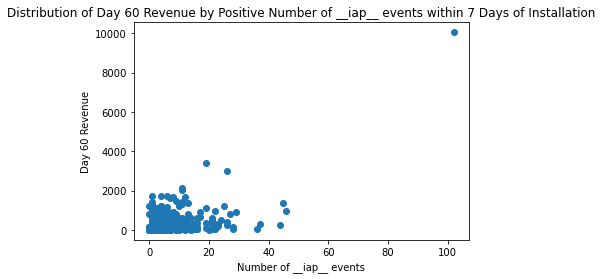

In [69]:
# Distribution of Day 60 Positive Revenue by Number of __iap__ events within 7 Days of Installation
plt.scatter(events_daily_d60[events_daily_d60['revenue_d60'] > 0]['iap_total']\
            , events_daily_d60[events_daily_d60['revenue_d60'] > 0]['revenue_d60'])
plt.title('Distribution of Day 60 Revenue by Positive Number of __iap__ events within 7 Days of Installation')
plt.xlabel('Number of __iap__ events')
plt.ylabel('Day 60 Revenue')

Text(0, 0.5, 'Day 60 Revenue')

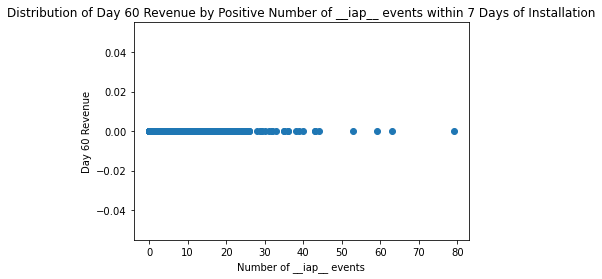

In [70]:
# Distribution of Day 60 Zero Revenue by Number of __iap__ events within 7 Days of Installation
plt.scatter(events_daily_d60[events_daily_d60['revenue_d60'] == 0]['iap_total']\
            , events_daily_d60[events_daily_d60['revenue_d60'] == 0]['revenue_d60'])
plt.title('Distribution of Day 60 Revenue by Positive Number of __iap__ events within 7 Days of Installation')
plt.xlabel('Number of __iap__ events')
plt.ylabel('Day 60 Revenue')

Interestingly, when the total number of __iap__ events within 7 days of installation was more than 50, there's no revenue(payments) from users on day 60, except for an outlier (top right corner of the first graph). A couple of possible reasons: 
* Data collection was biased or not complete. In other words, we simply didn't have sufficent data on day 60 for users with more than 50 iap events within 7 days of installation.
* Players that made more than 50 payments within 7 days of installation were easier to get hooked up by a game, but they might just be tired of this game faster, too. As they explored more features and functions of this game within the first week of installation, their silent reaction on day 60 might tell something about this game's sustainability.
* For users with the number of iap events between 0 and 50, there's also a relatively downwards slope. This vaguely suggests that users made more payments within a week of installation might not be interested in paying much later on day 60.

Text(0, 0.5, 'Day 60 Revenue')

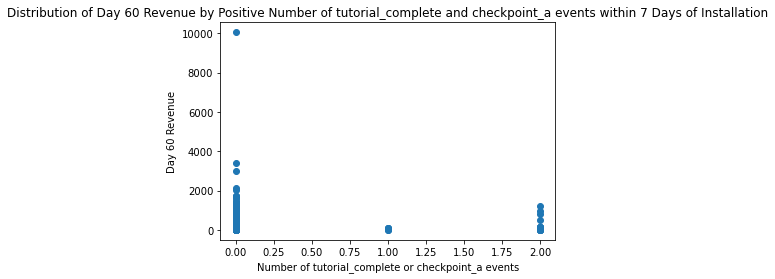

In [71]:
# Distribution of Day 60 Positive Revenue by Number of tutorial_complete and checkpoint_a events within 7 Days of Installation
plt.scatter(events_daily_d60[events_daily_d60['revenue_d60'] > 0]['tutorial_a_total']\
            , events_daily_d60[events_daily_d60['revenue_d60'] > 0]['revenue_d60'])
plt.title('Distribution of Day 60 Revenue by Positive Number of tutorial_complete and checkpoint_a events within 7 Days of Installation')
plt.xlabel('Number of tutorial_complete or checkpoint_a events')
plt.ylabel('Day 60 Revenue')

Text(0, 0.5, 'Day 60 Revenue')

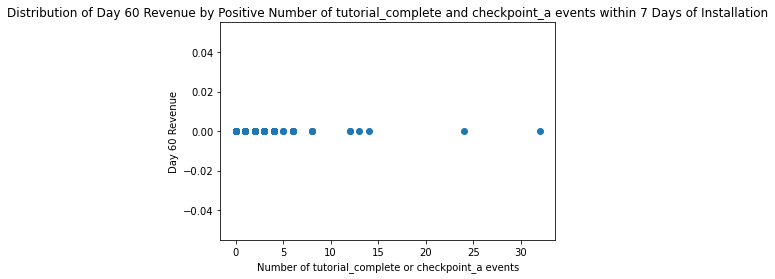

In [72]:
# Distribution of Day 60 Zero Revenue by Number of tutorial_complete and checkpoint_a events within 7 Days of Installation
plt.scatter(events_daily_d60[events_daily_d60['revenue_d60'] == 0]['tutorial_a_total']\
            , events_daily_d60[events_daily_d60['revenue_d60'] == 0]['revenue_d60'])
plt.title('Distribution of Day 60 Revenue by Positive Number of tutorial_complete and checkpoint_a events within 7 Days of Installation')
plt.xlabel('Number of tutorial_complete or checkpoint_a events')
plt.ylabel('Day 60 Revenue')

In [73]:
# Remove an outlier
# When iap_total > 70, there's an extreme large day 60 revenue associated with a user, contradicting zeros
events_daily_d60[events_daily_d60['iap_total'] > 70]

,user,iap_total,tutorial_a_total,revenue_d60
23252,5366407237799498667,102,0,10042.698
24118,5939157427975081386,79,0,0.000


In [74]:
# When tutorial_a_total = 0, there's an extreme large day 60 revenue associated with a user, more than twice as others
events_daily_d60[(events_daily_d60['tutorial_a_total'] == 0) & (events_daily_d60['revenue_d60'] > 7000)]

,user,iap_total,tutorial_a_total,revenue_d60
23252,5366407237799498667,102,0,10042.698


In [75]:
# The same user indeed. Remove this user from the users table. 
# Later will use the users table as the left table in the left join.
users_df = users_df.drop(users_df[users_df['user'] == 5366407237799498667].index)

The variation of 'tutorial_a_total' didn't indicate much about the variation of values of revenue on day 60. I include 'iap_total' in models.

In [76]:
events_df.columns

Index(['user', 'event', 'event_time', 'event_datetime', 'install_datetime',
       'events_day_diff', 'iap_or_not', 'events_category', 'tutorial_a'],
      dtype='object')

In [77]:
# Summarize daily events (sum of 'events_category')
events_daily_df = events_df.groupby(['user', 'events_day_diff'])\
                           .agg(events_type_daily = ('events_category', 'sum')\
                               , iap_total = ('iap_or_not', 'sum'))\
                           .reset_index()

In [78]:
events_daily_df.head()

,user,events_day_diff,events_type_daily,iap_total
0,-9223024671825712078,7,12,3
1,-9222449106698282755,1,6,0
2,-9222407629623737699,6,4,1
3,-9222407629623737699,7,8,2
4,-9221675257351750983,1,3,0


In [79]:
# Create a new column as the multiple of events_type_daily and iap_total
# Because when iap_total = 0, we don't need a positive total number of irrelevant events to confuse algorithms
events_daily_df['iap_times_total_events'] = events_daily_df['events_type_daily'] * events_daily_df['iap_total']

In [80]:
events_daily_pivot = events_daily_df.pivot(index=['user']\
                                   , columns='events_day_diff'\
                                   , values=['iap_times_total_events'])
events_daily_pivot.head()

iap_times_total_events                            
events_day_diff                           1   2   3   4   5     6     7
user                                                                   
-9223024671825712078                    NaN NaN NaN NaN NaN   NaN  36.0
-9222449106698282755                    0.0 NaN NaN NaN NaN   NaN   NaN
-9222407629623737699                    NaN NaN NaN NaN NaN   4.0  16.0
-9221675257351750983                    0.0 NaN NaN NaN NaN   NaN   NaN
-9221115360712779506                    NaN NaN NaN NaN NaN  36.0   4.0

In [81]:
# Reshape the pivot table
events_daily_pivot.columns = [c[0] + "_" + str(c[1]) for c in events_daily_pivot.columns]
events_daily_pivot = events_daily_pivot.reset_index()
events_daily_pivot.head()

,user,iap_times_total_events_1,iap_times_total_events_2,iap_times_total_events_3,iap_times_total_events_4,iap_times_total_events_5,iap_times_total_events_6,iap_times_total_events_7
0,-9223024671825712078,NaN,NaN,NaN,NaN,NaN,NaN,36.0
1,-9222449106698282755,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,-9222407629623737699,NaN,NaN,NaN,NaN,NaN,4.0,16.0
3,-9221675257351750983,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,-9221115360712779506,NaN,NaN,NaN,NaN,NaN,36.0,4.0


In [82]:
# Add events and revenue to the users table
users_df = users_df.merge(events_daily_pivot, how = 'left', on = 'user')
users_df = users_df.merge(rev_daily, how = 'left', on = 'user')
users_df.head()

,user,platform,channel,geo,install_date,install_datetime,iap_times_total_events_1,iap_times_total_events_2,iap_times_total_events_3,iap_times_total_events_4,...,iap_times_total_events_6,iap_times_total_events_7,revenue_d60,rev_day_1,rev_day_2,rev_day_3,rev_day_4,rev_day_5,rev_day_6,rev_day_7
0,-6850362954315242018,purple,Mice,AB,2020-11-03,2020-11-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7863223365093340651,purple,Mice,AB,2020-11-03,2020-11-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-5844463704494523566,purple,Mice,AB,2020-11-03,2020-11-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2710245180531833391,purple,Mice,AB,2020-11-03,2020-11-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1227926074670215435,purple,Mice,AB,2020-11-03,2020-11-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# If a user didn't have an event or revenue within 7 days of installation, or didn't have revenue on day 60: set 0
users_df = users_df.fillna(0)

In [84]:
users_df.head()

,user,platform,channel,geo,install_date,install_datetime,iap_times_total_events_1,iap_times_total_events_2,iap_times_total_events_3,iap_times_total_events_4,...,iap_times_total_events_6,iap_times_total_events_7,revenue_d60,rev_day_1,rev_day_2,rev_day_3,rev_day_4,rev_day_5,rev_day_6,rev_day_7
0,-6850362954315242018,purple,Mice,AB,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7863223365093340651,purple,Mice,AB,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5844463704494523566,purple,Mice,AB,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2710245180531833391,purple,Mice,AB,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1227926074670215435,purple,Mice,AB,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data presented sparsity. Tree algorithms might not perform well.

In [85]:
# Check correlation between variables
main_df = users_df.drop('user', axis = 1)
correlations_vars = main_df.corr()
corr_unstack = correlations_vars.unstack()
# drop_duplicates omits the 1 correlation of a variable and itself
corr_st = corr_unstack.sort_values(kind="quicksort").drop_duplicates()
corr_st[-25:-1]

rev_day_4                 iap_times_total_events_5    0.231243
rev_day_2                 rev_day_3                   0.236003
iap_times_total_events_3  rev_day_5                   0.256191
                          iap_times_total_events_4    0.256556
rev_day_3                 iap_times_total_events_4    0.257891
iap_times_total_events_6  rev_day_4                   0.259379
iap_times_total_events_4  rev_day_5                   0.261235
rev_day_3                 rev_day_1                   0.265113
rev_day_2                 rev_day_5                   0.275963
rev_day_1                 rev_day_2                   0.290709
rev_day_3                 rev_day_4                   0.291751
                          rev_day_5                   0.324612
rev_day_5                 rev_day_4                   0.327903
rev_day_6                 rev_day_5                   0.328376
iap_times_total_events_4  iap_times_total_events_6    0.384484
rev_day_4                 rev_day_6                   0

Note:
* The revenue on day 60 isn't highly correlated (correlation > 30%) with any variable.
* High correlation (>30%) presents among several features. The highest correlation was 77%. High correlation could cause problems in Causal Inference. The main task is prediction here. I will check whether PCA pipelines help reduce prediction error at all later.

In [86]:
main_df.columns

Index(['platform', 'channel', 'geo', 'install_date', 'install_datetime',
       'iap_times_total_events_1', 'iap_times_total_events_2',
       'iap_times_total_events_3', 'iap_times_total_events_4',
       'iap_times_total_events_5', 'iap_times_total_events_6',
       'iap_times_total_events_7', 'revenue_d60', 'rev_day_1', 'rev_day_2',
       'rev_day_3', 'rev_day_4', 'rev_day_5', 'rev_day_6', 'rev_day_7'],
      dtype='object')

In [87]:
main_df_ddp = main_df.drop_duplicates(subset=['platform', 'channel', 'geo'\
                                              , 'iap_times_total_events_1', 'iap_times_total_events_2'\
                                              ,'iap_times_total_events_3', 'iap_times_total_events_4'\
                                              ,'iap_times_total_events_5', 'iap_times_total_events_6'\
                                              ,'iap_times_total_events_7', 'rev_day_1', 'rev_day_2'\
                                              ,'rev_day_3', 'rev_day_4', 'rev_day_5', 'rev_day_6', 'rev_day_7'])
main_df.shape, main_df_ddp.shape

((461853, 20), (6922, 20))

In [88]:
# Summarize events and revenue for comparison among platform, channel and geo
main_df_ddp['total_events'] = main_df_ddp.iloc[:, 5:12].sum(axis=1)
main_df_ddp['total_revenue'] = main_df_ddp.iloc[:, 13:20].sum(axis=1)

In [89]:
# Check consumer behavior per combination of platform, channel and geo
checks_combined = main_df_ddp.groupby(['platform', 'channel', 'geo'])\
                             .agg(total_events_combo = ('total_events', 'sum')\
                                  , total_users = ('install_datetime', 'size')\
                                  , total_revenue_d60 = ('revenue_d60', 'sum')\
                                  , total_revenue_first7 = ('total_revenue', 'sum'))\
                             .reset_index()
checks_combined.head()

,platform,channel,geo,total_events_combo,total_users,total_revenue_d60,total_revenue_first7
0,orange,Frogs,AB,60839.0,846,12144.064,422323.788
1,orange,Frogs,BC,6882.0,223,722.858,59942.096
2,orange,Frogs,CD,2803.0,80,516.088,22689.272
3,orange,Frogs,DE,0.0,1,0.000,0.000
4,orange,Geese,AB,11066.0,190,2391.712,84000.948


In [90]:
# Compute the avarages of revenue/events per user corresponding to each combo
checks_combined['avg_revenue_d60'] = checks_combined['total_revenue_d60'] / checks_combined['total_users']
checks_combined['avg_events_first7'] = checks_combined['total_events_combo'] / checks_combined['total_users']
checks_combined['avg_revenue_first7'] = checks_combined['total_revenue_first7'] / checks_combined['total_users']
checks_combined.head()

,platform,channel,geo,total_events_combo,total_users,total_revenue_d60,total_revenue_first7,avg_revenue_d60,avg_events_first7,avg_revenue_first7
0,orange,Frogs,AB,60839.0,846,12144.064,422323.788,14.354686,71.913712,499.200695
1,orange,Frogs,BC,6882.0,223,722.858,59942.096,3.241516,30.860987,268.798637
2,orange,Frogs,CD,2803.0,80,516.088,22689.272,6.451100,35.037500,283.615900
3,orange,Frogs,DE,0.0,1,0.000,0.000,0.000000,0.000000,0.000000
4,orange,Geese,AB,11066.0,190,2391.712,84000.948,12.587958,58.242105,442.110253


In [91]:
checks_combined.sort_values(by = ['total_revenue_d60', 'total_revenue_first7', 'total_events_combo'])

,platform,channel,geo,total_events_combo,total_users,total_revenue_d60,total_revenue_first7,avg_revenue_d60,avg_events_first7,avg_revenue_first7
3,orange,Frogs,DE,0.0,1,0.000,0.000,0.000000,0.000000,0.000000
15,purple,Frogs,DE,0.0,1,0.000,0.000,0.000000,0.000000,0.000000
14,purple,Frogs,CD,215.0,18,0.000,2809.902,0.000000,11.944444,156.105667
19,purple,Geese,DE,300.0,22,0.000,4102.106,0.000000,13.636364,186.459364
7,orange,Geese,DE,747.0,36,0.000,4672.568,0.000000,20.750000,129.793556
6,orange,Geese,CD,418.0,23,13.702,4017.724,0.595739,18.173913,174.683652
5,orange,Geese,BC,1860.0,61,120.714,20106.414,1.978918,30.491803,329.613344
18,purple,Geese,CD,300.0,12,137.578,3289.348,11.464833,25.000000,274.112333
17,purple,Geese,BC,1408.0,58,176.824,20393.846,3.048690,24.275862,351.618034
13,purple,Frogs,BC,2869.0,109,241.180,23575.004,2.212661,26.321101,216.284440


Text(0, 0.5, 'Total Revenue on Day 60')

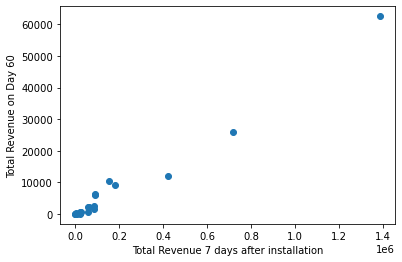

In [92]:
plt.scatter(checks_combined['total_revenue_first7'], checks_combined['total_revenue_d60'])
plt.xlabel('Total Revenue 7 days after installation')
plt.ylabel('Total Revenue on Day 60')
# Looks linear

Text(0, 0.5, 'Total Revenue on Day 60')

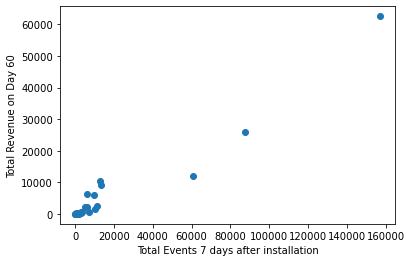

In [93]:
plt.scatter(checks_combined['total_events_combo'], checks_combined['total_revenue_d60'])
plt.xlabel('Total Events 7 days after installation')
plt.ylabel('Total Revenue on Day 60')
# Looks linear

Text(0, 0.5, 'Total Revenue on Day 60')

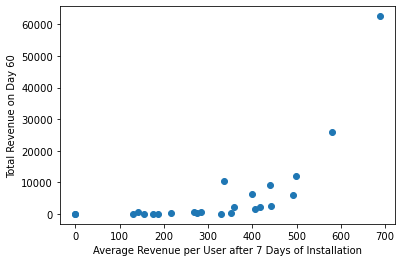

In [94]:
plt.scatter(checks_combined['avg_revenue_first7'], checks_combined['total_revenue_d60'])
plt.xlabel('Average Revenue per User after 7 Days of Installation')
plt.ylabel('Total Revenue on Day 60')
# Looks log linear

Text(0, 0.5, 'Total Revenue on Day 60')

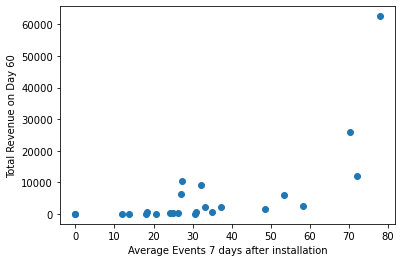

In [95]:
plt.scatter(checks_combined['avg_events_first7'], checks_combined['total_revenue_d60'])
plt.xlabel('Average Events 7 days after installation')
plt.ylabel('Total Revenue on Day 60')
# Looks log linear

After removing duplicates, two users belong to "orange Frogs DE" or "purple Frogs DE" combinations and didn't make a payment in the first seven days, nor on day 60. With such a small sample size, we couldn't read much into it. I don't have the relationshiop between platforms, channels and geos. Fortunately, these tow combinations were very unpopular. I will just assign $0 payment on day 60 to users that belong to these two combinations.

The above graphs show that total events and revenue 7 days after installation had approximately linear relationshiop with the revenue on day 60; average events and revenue per user 7 days after installation had approximately log-linear relationshiop with revenue on day 60. I'll incorporate total events/revenue 7 days after installation into models.

## Grouping Users according to Total Revenue on Day 60 across Combinations <a class="anchor" id="group"></a>

In [96]:
# Group combinations with similar ranges of day 60 revenue together
conditions = [checks_combined['total_revenue_d60'] < 100\
             , (checks_combined['total_revenue_d60'] >= 100) & (checks_combined['total_revenue_d60'] < 1000)\
             , (checks_combined['total_revenue_d60'] >= 1000) & (checks_combined['total_revenue_d60'] < 10000)\
             , checks_combined['total_revenue_d60'] >= 10000]
# Assign combo_category numbers
choices = [0, 1, 2, 3]
checks_combined['combo_category'] = np.select(conditions, choices, default=0)
checks_combined

,platform,channel,geo,total_events_combo,total_users,total_revenue_d60,total_revenue_first7,avg_revenue_d60,avg_events_first7,avg_revenue_first7,combo_category
0,orange,Frogs,AB,60839.0,846,12144.064,422323.788,14.354686,71.913712,499.200695,3
1,orange,Frogs,BC,6882.0,223,722.858,59942.096,3.241516,30.860987,268.798637,1
2,orange,Frogs,CD,2803.0,80,516.088,22689.272,6.451100,35.037500,283.615900,1
3,orange,Frogs,DE,0.0,1,0.000,0.000,0.000000,0.000000,0.000000,0
4,orange,Geese,AB,11066.0,190,2391.712,84000.948,12.587958,58.242105,442.110253,2
5,orange,Geese,BC,1860.0,61,120.714,20106.414,1.978918,30.491803,329.613344,1
6,orange,Geese,CD,418.0,23,13.702,4017.724,0.595739,18.173913,174.683652,0
7,orange,Geese,DE,747.0,36,0.000,4672.568,0.000000,20.750000,129.793556,0
8,orange,Mice,AB,87289.0,1243,25789.644,719977.046,20.747903,70.224457,579.225298,3
9,orange,Mice,BC,13134.0,407,9079.900,178626.216,22.309337,32.270270,438.885052,2


In [97]:
# Check the number of total users in each of three groups
checks_groups_users = checks_combined.groupby('combo_category')\
                                     .agg(users_sum = ('total_users', 'sum'))\
                                     .reset_index()
checks_groups_users

,combo_category,users_sum
0,0,101
1,1,722
2,2,1532
3,3,4567


I almost have no data for '0' combo category. Users under this category almost always had zero revenue on day 60 in the given data. For users fall into category '0,' I'll just predict their day 60 revenue as zero. Below is the modeling part of other three combo categories.

In [98]:
# Add combo_category to main_df_ddp
main_df_ddp = main_df_ddp.merge(checks_combined[['platform', 'channel', 'geo', 'combo_category']], how = 'left'\
                               , on = ['platform', 'channel', 'geo'])

In [99]:
main_df_ddp.head()

,platform,channel,geo,install_date,install_datetime,iap_times_total_events_1,iap_times_total_events_2,iap_times_total_events_3,iap_times_total_events_4,iap_times_total_events_5,...,rev_day_1,rev_day_2,rev_day_3,rev_day_4,rev_day_5,rev_day_6,rev_day_7,total_events,total_revenue,combo_category
0,purple,Mice,AB,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3
1,purple,Mice,BC,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3
2,purple,Mice,CD,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,2
3,purple,Mice,DE,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,2
4,purple,Mice,AB,2020-11-03,2020-11-03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,61.876,28.0,61.876,3


In [100]:
# Separate features and targets for the later splits
main_df_features = main_df_ddp.drop(['platform', 'channel', 'geo', 'revenue_d60', 'install_date', 'install_datetime'], axis = 1)
main_df_targets = main_df_ddp[['revenue_d60', 'combo_category']]

## Modeling <a class="anchor" id="model"></a>

In [101]:
# Train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(main_df_features\
                                                            [main_df_features['combo_category'] == 1]\
                                                            , main_df_targets\
                                                            [main_df_targets['combo_category'] == 1]['revenue_d60']\
                                                            , test_size = 0.3, random_state = 0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(main_df_features\
                                                            [main_df_features['combo_category'] == 2]\
                                                            , main_df_targets\
                                                            [main_df_targets['combo_category'] == 2]['revenue_d60']\
                                                            , test_size = 0.3, random_state = 0)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(main_df_features\
                                                            [main_df_features['combo_category'] == 3]\
                                                            , main_df_targets\
                                                            [main_df_targets['combo_category'] == 3]['revenue_d60']\
                                                            , test_size = 0.3, random_state = 0)

In [102]:
# User RMSE as a scoring metric, because I want to penalize extreme large errors (positive or negative)
metric = 'neg_root_mean_squared_error'

In [103]:
# Try simple OLS
linear_reg1 = LinearRegression().fit(X_train_1, y_train_1)
y_test_pred1_lr = linear_reg1.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred1_lr, squared=False))

14.92089605946834


In [104]:
# Lasso
lasso1 = Lasso(alpha= 0.003, random_state=1)
param_grid_lasso1 = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_lasso1 = GridSearchCV(estimator = lasso1, param_grid=param_grid_lasso1, cv=10, scoring=metric, n_jobs=-1)
search_lasso1.fit(X_train_1, y_train_1)
# Compute RMSE on test set
y_test_pred1_lasso = search_lasso1.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred1_lasso, squared=False))

14.920785201150435


In [109]:
# Lasso with å PCA pipeline
lasso1_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("lasso1", Lasso())
                          ])
param_grid_lassopca1 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            lasso1__alpha = np.linspace(0.0001, 0.001, 10)
                            )
search_pca_lasso1 = GridSearchCV(estimator = lasso1_pipe, param_grid=param_grid_lassopca1, cv=10, scoring=metric, n_jobs=-1)
search_pca_lasso1.fit(X_train_1, y_train_1)
# Compute RMSE on test set
y_test_pred1_lassopca = search_pca_lasso1.predict(X_test_1)
print(f"{search_pca_lasso1.best_params_}")
print(mean_squared_error(y_test_1, y_test_pred1_lassopca, squared=False))

{'lasso1__alpha': 0.001, 'reduce_dims__n_components': 0.75}
13.134720027377671


In [372]:
# Ridge.
ridge1 = Ridge(alpha= 0.003, random_state=1)
param_grid_ridge1 = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_ridge1 = GridSearchCV(estimator = ridge1, param_grid = param_grid_ridge1, cv=10, scoring=metric, n_jobs=-1)
search_ridge1.fit(X_train_1, y_train_1)
# Compute RMSE on test set
y_test_pred1_ridge = search_ridge1.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred1_ridge, squared=False))

14.920896034123997


In [112]:
# Ridge with å PCA pipeline
ridge1_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("ridge1", Ridge())
                          ])
param_grid_ridgepca1 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            ridge1__alpha = np.linspace(0.0001, 0.001, 10)
                            )
search_pca_ridge1 = GridSearchCV(estimator = ridge1_pipe, param_grid=param_grid_ridgepca1, cv=10, scoring=metric, n_jobs=-1)
search_pca_ridge1.fit(X_train_1, y_train_1)
# Compute RMSE on test set
y_test_pred1_ridgepca = search_pca_ridge1.predict(X_test_1)
print(f"{search_pca_ridge1.best_params_}")
print(mean_squared_error(y_test_1, y_test_pred1_ridgepca, squared=False))

{'reduce_dims__n_components': 0.75, 'ridge1__alpha': 0.001}
13.135095888632728


In [375]:
# Elastic Net.
elastic_net1 = ElasticNet(alpha= 0.0005, 
                         l1_ratio= 0.4, 
                         random_state=1)
param_grid_el1 = {
                'alpha' : np.linspace(0.0001, 0.001, 10),
                'l1_ratio' : np.linspace(0.6, 0.95, 20)
                }
search_el1 = GridSearchCV(estimator = elastic_net1, param_grid = param_grid_el1, cv=10, scoring=metric, n_jobs=-1)
search_el1.fit(X_train_1, y_train_1)
print(f"{search_el1.best_params_}")
# Compute RMSE on test set
y_test_pred1_el = search_el1.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred1_el, squared=False))

{'alpha': 0.001, 'l1_ratio': 0.95}
14.920790142418559


In [113]:
# Elastic Net with å PCA pipeline
el1_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("el1", ElasticNet())
                          ])
param_grid_el1 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            el1__alpha = np.linspace(0.0001, 0.001, 10),
                            el1__l1_ratio = np.linspace(0.6, 0.95, 20)
                            )
search_pca_el1 = GridSearchCV(estimator = el1_pipe, param_grid=param_grid_el1, cv=10, scoring=metric, n_jobs=-1)
search_pca_el1.fit(X_train_1, y_train_1)
# Compute RMSE on test set
y_test_pred1_elpca = search_pca_el1.predict(X_test_1)
print(f"{search_pca_el1.best_params_}")
print(mean_squared_error(y_test_1, y_test_pred1_elpca, squared=False))

{'el1__alpha': 0.001, 'el1__l1_ratio': 0.6, 'reduce_dims__n_components': 0.75}
13.134149929902904


In [361]:
# Decision Tree
metric = 'neg_root_mean_squared_error'
dt1 = DecisionTreeRegressor(max_depth=4, random_state=1)
param_grid_dt1=[{
                'max_depth': range(4, 7)
                }]
# Increase the number of folds from 3 to 5 according to the results of KNN above
search_dt1 = GridSearchCV(estimator = dt1, param_grid=param_grid_dt1, cv=10, scoring=metric, n_jobs=-1)   
search_dt1.fit(X_train_1, y_train_1)
print(f"{search_dt1.best_params_}")

{'max_depth': 5}


In [362]:
# Compute RMSE on test set
y_test_pred1_dt = search_dt.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred1_dt, squared=False))

55.29158223129511


In [116]:
# Decision Tree with a PCA pipeline.
dt1_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("dt1", DecisionTreeRegressor())
                      ])


dt1_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                        dt1__max_depth = range(2,4)
                       )
search_dt1_pipe = GridSearchCV(estimator = dt1_pipe, param_grid = dt1_param_grid, cv = 10, n_jobs=-1)   
search_dt1_pipe.fit(X_train_1, y_train_1)
print(f"{search_dt1_pipe.best_params_}")
# Compute RMSE on test set
y_test_pred_dt1_pipe = search_dt1_pipe.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred_dt1_pipe, squared=False))

{'dt1__max_depth': 3, 'reduce_dims__n_components': 0.95}
38.559904262952976


In [366]:
# Random Forest
rdf1 = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=1)
param_grid_rdf1=[{
                'max_depth': range(4,7),
                'n_estimators': [50, 100, 150]
                }]
search_rdf1 = GridSearchCV(estimator = rdf1, param_grid=param_grid_rdf1, cv = 10, scoring=metric, n_jobs=-1)
search_rdf1.fit(X_train_1, y_train_1)
print(f"{search_rdf1.best_params_}")

{'max_depth': 5, 'n_estimators': 100}


In [367]:
# Compute RMSE on test set
y_test_pred1_rdf = search_rdf1.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred1_rdf, squared=False))

17.987924880306633


In [118]:
# Random Forest with a PCA pipeline.
rdf1_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("rdf1", RandomForestRegressor())
                      ])


rdf1_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                       rdf1__max_depth = range(2,4),
                       rdf1__n_estimators = range(50, 100)
                      )
search_rdf1_pipe = GridSearchCV(estimator = rdf1_pipe, param_grid = rdf1_param_grid, cv = 10, n_jobs=-1)   
search_rdf1_pipe.fit(X_train_1, y_train_1)
print(f"{search_rdf1_pipe.best_params_}")
# Compute RMSE on test set
y_test_pred_rdf1_pipe = search_rdf1_pipe.predict(X_test_1)
print(mean_squared_error(y_test_1, y_test_pred_rdf1_pipe, squared=False))

{'rdf1__max_depth': 2, 'rdf1__n_estimators': 52, 'reduce_dims__n_components': 0.95}
17.90498380896533


Linear models outperformed tree models for users of combinations with total revenue on day 60 between 100 and 1,000 dollar (combo_category = 1). Even a simple OLS model without cross-validation outperformed Random Forest on the out-of-sample data by around 3 dollar. This was as expected, as tree algorithms generally are sensitive to the sparsity of data. However, this is not the case for users fell into '2' combo_category, for whom tree algorithms had much lower RMSE.

In [377]:
# Try simple OLS
linear_reg2 = LinearRegression().fit(X_train_2, y_train_2)
y_test_pred2_lr = linear_reg2.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred2_lr, squared=False))

116.58079872048418


In [379]:
# Lasso
lasso2 = Lasso(alpha= 0.003, random_state=1)
param_grid_lasso2 = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_lasso2 = GridSearchCV(estimator = lasso2, param_grid=param_grid_lasso2, cv=10, scoring=metric, n_jobs=-1)
search_lasso2.fit(X_train_2, y_train_2)
# Compute RMSE on test set
y_test_pred2_lasso = search_lasso2.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred2_lasso, squared=False))

116.58061744917924


In [119]:
# Lasso with å PCA pipeline
lasso2_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("lasso2", Lasso())
                          ])
param_grid_lassopca2 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            lasso2__alpha = np.linspace(0.0001, 0.001, 10)
                            )
search_pca_lasso2 = GridSearchCV(estimator = lasso2_pipe, param_grid=param_grid_lassopca2, cv=10, scoring=metric, n_jobs=-1)
search_pca_lasso2.fit(X_train_2, y_train_2)
# Compute RMSE on test set
y_test_pred_lassopca2 = search_pca_lasso2.predict(X_test_2)
print(f"{search_pca_lasso2.best_params_}")
print(mean_squared_error(y_test_2, y_test_pred_lassopca2, squared=False))

{'lasso2__alpha': 0.001, 'reduce_dims__n_components': 0.75}
100.2315146878858


In [381]:
# Ridge.
ridge2 = Ridge(alpha= 0.003, random_state=1)
param_grid_ridge2 = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_ridge2 = GridSearchCV(estimator = ridge2, param_grid = param_grid_ridge2, cv=10, scoring=metric, n_jobs=-1)
search_ridge2.fit(X_train_2, y_train_2)
# Compute RMSE on test set
y_test_pred2_ridge = search_ridge2.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred2_ridge, squared=False))

116.58079849386351


In [130]:
# Ridge with å PCA pipeline
ridge2_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("ridge2", Ridge())
                          ])
param_grid_ridgepca2 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            ridge2__alpha = np.linspace(0.0001, 0.001, 10)
                            )
search_pca_ridge2 = GridSearchCV(estimator = ridge2_pipe, param_grid=param_grid_ridgepca2, cv=10, scoring=metric, n_jobs=-1)
search_pca_ridge2.fit(X_train_2, y_train_2)
# Compute RMSE on test set
y_test_pred2_ridgepca = search_pca_ridge2.predict(X_test_2)
print(f"{search_pca_ridge2.best_params_}")
print(mean_squared_error(y_test_2, y_test_pred2_ridgepca, squared=False))

{'reduce_dims__n_components': 0.75, 'ridge2__alpha': 0.001}
100.23421688003911


In [382]:
# Elastic Net.
elastic_net2 = ElasticNet(alpha= 0.0005, 
                         l1_ratio= 0.4, 
                         random_state=1)
param_grid_el2 = {
                'alpha' : np.linspace(0.0001, 0.001, 10),
                'l1_ratio' : np.linspace(0.6, 0.95, 20)
                }
search_el2 = GridSearchCV(estimator = elastic_net2, param_grid = param_grid_el2, cv=10, scoring=metric, n_jobs=-1)
search_el2.fit(X_train_2, y_train_2)
print(f"{search_el2.best_params_}")
# Compute RMSE on test set
y_test_pred2_el = search_el2.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred2_el, squared=False))

{'alpha': 0.001, 'l1_ratio': 0.95}
116.58061257832246


In [121]:
# Elastic Net with å PCA pipeline
el2_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("el2", ElasticNet())
                          ])
param_grid_el2 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            el2__alpha = np.linspace(0.0001, 0.001, 10),
                            el2__l1_ratio = np.linspace(0.6, 0.95, 20)
                            )
search_pca_el2 = GridSearchCV(estimator = el2_pipe, param_grid=param_grid_el2, cv=10, scoring=metric, n_jobs=-1)
search_pca_el2.fit(X_train_2, y_train_2)
# Compute RMSE on test set
y_test_pred_elpca2 = search_pca_el2.predict(X_test_2)
print(f"{search_pca_el2.best_params_}")
print(mean_squared_error(y_test_2, y_test_pred_elpca2, squared=False))

{'el2__alpha': 0.001, 'el2__l1_ratio': 0.6, 'reduce_dims__n_components': 0.75}
100.21949372587798


In [392]:
# Decision Tree
metric = 'neg_root_mean_squared_error'
dt2 = DecisionTreeRegressor(max_depth=4, random_state=1)
param_grid_dt2=[{
                'max_depth': range(4, 7)
                }]
# Increase the number of folds from 3 to 5 according to the results of KNN above
search_dt2 = GridSearchCV(estimator = dt2, param_grid=param_grid_dt2, cv=10, scoring=metric, n_jobs=-1)   
search_dt2.fit(X_train_2, y_train_2)
print(f"{search_dt.best_params_}")
# Compute RMSE on test set
y_test_pred2_dt = search_dt2.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred2_dt, squared=False))

{'max_depth': 5}
175.48382092611163


In [124]:
# Decision Tree with a PCA pipeline.
dt2_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("dt2", DecisionTreeRegressor())
                      ])


dt2_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                        dt2__max_depth = range(2,4)
                       )
search_dt2_pipe = GridSearchCV(estimator = dt2_pipe, param_grid = dt2_param_grid, cv = 10, n_jobs=-1)   
search_dt2_pipe.fit(X_train_2, y_train_2)
print(f"{search_dt2_pipe.best_params_}")
# Compute RMSE on test set
y_test_pred_dt2_pipe = search_dt1_pipe.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred_dt2_pipe, squared=False))

{'dt2__max_depth': 2, 'reduce_dims__n_components': 0.95}
78.02729971332344


In [385]:
# Random Forest
rdf2 = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=1)
param_grid_rdf2=[{
                'max_depth': range(4,7),
                'n_estimators': [50, 100, 150]
                }]
search_rdf2 = GridSearchCV(estimator = rdf2, param_grid=param_grid_rdf2, cv = 10, scoring=metric, n_jobs=-1)
search_rdf2.fit(X_train_2, y_train_2)
print(f"{search_rdf2.best_params_}")
# Compute RMSE on test set
y_test_pred2_rdf = search_rdf2.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred2_rdf, squared=False))

{'max_depth': 4, 'n_estimators': 100}
91.40176835216063


In [127]:
# Random Forest with a PCA pipeline.
rdf2_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("rdf2", RandomForestRegressor())
                      ])


rdf2_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                       rdf2__max_depth = range(2,4),
                       rdf2__n_estimators = range(50, 100)
                      )
search_rdf2_pipe = GridSearchCV(estimator = rdf2_pipe, param_grid = rdf2_param_grid, cv = 10, n_jobs=-1)   
search_rdf2_pipe.fit(X_train_2, y_train_2)
print(f"{search_rdf2_pipe.best_params_}")
# Compute RMSE on test set
y_test_pred_rdf_pipe2 = search_rdf2_pipe.predict(X_test_2)
print(mean_squared_error(y_test_2, y_test_pred_rdf_pipe2, squared=False))

{'rdf2__max_depth': 2, 'rdf2__n_estimators': 61, 'reduce_dims__n_components': 0.95}
77.69430812360034


For users of combinations with total revenue on day 60 between 1,000 and 10,000, Random Forest with 100 trees outperformed Decision Tree and Linear Regression models. 

In [386]:
# Try simple OLS
linear_reg3 = LinearRegression().fit(X_train_3, y_train_3)
y_test_pred3_lr = linear_reg3.predict(X_test_3)
print(mean_squared_error(y_test_3, y_test_pred3_lr, squared=False))

153.91840695600624


In [387]:
# Lasso: Best for combo_category = 1.
lasso3 = Lasso(alpha= 0.003, random_state=1)
param_grid_lasso3 = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_lasso3 = GridSearchCV(estimator = lasso3, param_grid=param_grid_lasso3, cv=10, scoring=metric, n_jobs=-1)
search_lasso3.fit(X_train_3, y_train_3)
# Compute RMSE on test set
y_test_pred3_lasso = search_lasso3.predict(X_test_3)
print(mean_squared_error(y_test_3, y_test_pred3_lasso, squared=False))

153.96647049328675


In [129]:
# Lasso with å PCA pipeline
lasso3_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("lasso3", Lasso())
                          ])
param_grid_lassopca3 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            lasso3__alpha = np.linspace(0.0001, 0.001, 10)
                            )
search_pca_lasso3 = GridSearchCV(estimator = lasso3_pipe, param_grid=param_grid_lassopca3, cv=10, scoring=metric, n_jobs=-1)
search_pca_lasso3.fit(X_train_3, y_train_3)
# Compute RMSE on test set
y_test_pred_lassopca3 = search_pca_lasso3.predict(X_test_3)
print(f"{search_pca_lasso3.best_params_}")
print(mean_squared_error(y_test_3, y_test_pred_lassopca3, squared=False))

{'lasso3__alpha': 0.001, 'reduce_dims__n_components': 0.95}
154.13188302305355


In [389]:
# Ridge.
ridge3 = Ridge(alpha= 0.003, random_state=1)
param_grid_ridge3 = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_ridge3 = GridSearchCV(estimator = ridge3, param_grid = param_grid_ridge3, cv=10, scoring=metric, n_jobs=-1)
search_ridge3.fit(X_train_3, y_train_3)
# Compute RMSE on test set
y_test_pred3_ridge = search_ridge3.predict(X_test_3)
print(mean_squared_error(y_test_3, y_test_pred3_ridge, squared=False))

153.96647605441478


In [126]:
# Ridge with å PCA pipeline
ridge3_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("ridge3", Ridge())
                          ])
param_grid_ridgepca3 = dict(
                            reduce_dims__n_components = [0.75, 0.95],
                            ridge3__alpha = np.linspace(0.0001, 0.001, 10)
                            )
search_pca_ridge3 = GridSearchCV(estimator = ridge3_pipe, param_grid=param_grid_ridgepca3, cv=10, scoring=metric, n_jobs=-1)
search_pca_ridge3.fit(X_train_3, y_train_3)
# Compute RMSE on test set
y_test_pred3_ridgepca = search_pca_ridge3.predict(X_test_3)
print(f"{search_pca_ridge3.best_params_}")
print(mean_squared_error(y_test_3, y_test_pred3_ridgepca, squared=False))

{'reduce_dims__n_components': 0.95, 'ridge3__alpha': 0.001}
154.13203158343234


In [390]:
# Elastic Net.
elastic_net3 = ElasticNet(alpha= 0.0005, 
                         l1_ratio= 0.4, 
                         random_state=1)
param_grid_el3 = {
                'alpha' : np.linspace(0.0001, 0.001, 10),
                'l1_ratio' : np.linspace(0.6, 0.95, 20)
                }
search_el3 = GridSearchCV(estimator = elastic_net3, param_grid = param_grid_el3, cv=10, scoring=metric, n_jobs=-1)
search_el3.fit(X_train_3, y_train_3)
print(f"{search_el3.best_params_}")
# Compute RMSE on test set
y_test_pred3_el = search_el3.predict(X_test_3)
print(mean_squared_error(y_test_3, y_test_pred3_el, squared=False))

{'alpha': 0.001, 'l1_ratio': 0.95}
153.96647072193045


In [391]:
# Decision Tree
dt3 = DecisionTreeRegressor(max_depth=4, random_state=1)
param_grid_dt3=[{
                'max_depth': range(4, 7)
                }]
# Increase the number of folds from 3 to 5 according to the results of KNN above
search_dt3 = GridSearchCV(estimator = dt3, param_grid=param_grid_dt3, cv=10, scoring=metric, n_jobs=-1)   
search_dt3.fit(X_train_3, y_train_3)
print(f"{search_dt.best_params_}")
# Compute RMSE on test set
y_test_pred3_dt = search_dt3.predict(X_test_3)
print(mean_squared_error(y_test_3, y_test_pred3_dt, squared=False))

{'max_depth': 5}
172.94801692154445


In [393]:
# Random Forest
rdf3 = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=1)
param_grid_rdf3=[{
                'max_depth': range(4,7),
                'n_estimators': [50, 100, 150]
                }]
search_rdf3 = GridSearchCV(estimator = rdf3, param_grid=param_grid_rdf3, cv = 10, scoring=metric, n_jobs=-1)
search_rdf3.fit(X_train_3, y_train_3)
print(f"{search_rdf2.best_params_}")
# Compute RMSE on test set
y_test_pred3_rdf = search_rdf3.predict(X_test_3)
print(mean_squared_error(y_test_3, y_test_pred3_rdf, squared=False))

{'max_depth': 4, 'n_estimators': 100}
156.5750567543436


In [128]:
# Random Forest with a PCA pipeline.
rdf3_pipe = Pipeline([("scale", StandardScaler()),
                       ("reduce_dims", PCA()),
                       ("rdf3", RandomForestRegressor())
                      ])


rdf3_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                       rdf3__max_depth = range(2,4),
                       rdf3__n_estimators = range(50, 100)
                      )
search_rdf3_pipe = GridSearchCV(estimator = rdf3_pipe, param_grid = rdf3_param_grid, cv = 10, n_jobs=-1)   
search_rdf3_pipe.fit(X_train_3, y_train_3)
print(f"{search_rdf3_pipe.best_params_}")
# Compute RMSE on test set
y_test_pred_rdf_pipe3 = search_rdf3_pipe.predict(X_test_3)
print(mean_squared_error(y_test_3, y_test_pred_rdf_pipe3, squared=False))

{'rdf3__max_depth': 2, 'rdf3__n_estimators': 92, 'reduce_dims__n_components': 0.75}
154.89453704132856


For users of combinations with total revenue on day 60 greater than 10,000, a simple OLS model outperformed all the other models on the out-of-sample data.

## References <a class="anchor" id="References"></a>

https://stackoverflow.com/questions/19231871/convert-unix-time-to-readable-date-in-pandas-dataframe

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

https://stackoverflow.com/questions/32544925/cannot-import-scikit-learn

## Appendix: Falied Attempts <a class="anchor" id="Appendix"></a>

* To predict day 60 revenue, I first predicted at the user level without extra information, such as platform, channel and geo. The result wasn't very ideal with around 20 dollar more RMSE for tree algorithms compared to the solution submitted. Also, these prediction results suggest that error on the unseen test set was smaller than the error on the trainging set. This meant a simple overall model had a __underfitting__ issue. Therefore, I started looking for more complicated solutions.
* My second thought was separating the prediction task into two stages: 
    
    * Binary classification: predicting whether a user will have payment on day 60 or not
    
    * Regression: if a user is predicted to have day 60 payments, how much?

The second bullet point above didn't work, mostly because I had very few unique observations if I only used event features in the binary classification part. Below are just some code for these attempts, such as the modeling results of a simple overall model, and an upsampling pipeline with KNN.

In [146]:
# The first attempt: an overall and simple model
X_train, X_test, y_train, y_test = train_test_split(main_df_events_rev_7ds\
                                                    .loc[:, main_df_events_rev_7ds.columns != 'revenue_d60']\
                                                    , main_df_events_rev_7ds['revenue_d60']\
                                                    , test_size = 0.3, random_state = 0)

In [148]:
# Decision Tree
metric = 'neg_root_mean_squared_error'
dt = DecisionTreeRegressor(max_depth=4, random_state=1)
param_grid_dt=[{
                'max_depth': range(4, 7)
                }]
# Increase the number of folds from 3 to 5 according to the results of KNN above
search_dt = GridSearchCV(estimator = dt, param_grid=param_grid_dt, cv=10, scoring=metric, n_jobs=-1)   
search_dt.fit(X_train, y_train)
print(f"{search_dt.best_params_}")
print(f"{-(search_dt.best_score_):.4}")

{'max_depth': 4}
95.33


In [149]:
# Compute RMSE on test set
y_test_pred_dt = search_dt.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_dt, squared=False))

74.4165597484266


In [150]:
# Random Forest
rdf = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=1)
param_grid_rdf=[{
                'max_depth': range(4,7),
                'n_estimators': [50, 100]
                }]
search_rdf = GridSearchCV(estimator = rdf, param_grid=param_grid_rdf, cv = 10, scoring=metric, n_jobs=-1)
search_rdf.fit(X_train, y_train)
print(f"{search_rdf.best_params_}")
print(f"{-(search_rdf.best_score_):.4}")

{'max_depth': 4, 'n_estimators': 100}
82.54


In [152]:
# Compute RMSE on test set
y_test_pred_rdf = search_rdf.predict(X_test)
print(mean_squared_error(y_test, y_test_pred_rdf, squared=False))

75.23905890085562


In [255]:
# KNN with an upsampling pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train_cl1 = scaler.fit_transform(X_train_cl1)
model_KNN_cl = Pipeline([
                        ('sampling', SMOTE()),
                        ('KNN', KNeighborsClassifier(n_neighbors=5))
                        ])
# Define parametres for hypertuning
params_KNN_cl = [{'KNN__n_neighbors': (5, 15, 20, 30)}]
# Precision: penalize false positive because they increase our cost-per-installation
grid_KNN_cl = GridSearchCV(estimator=model_KNN_cl, param_grid=params_KNN_cl, cv = 5, scoring = 'accuracy',  n_jobs=-1) 
grid_KNN_cl.fit(scaled_X_train_cl1, y_train_cl1)
y_test_pred1_KNN = grid_KNN_cl.predict(X_test_cl1)
print(grid_KNN_cl.best_params_)
print(accuracy_score(y_test_cl1, y_test_pred1_KNN))

{'KNN__n_neighbors': 20}
0.484375
